In [1]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
# 2. Load Dataset
data = pd.read_csv('/content/drive/MyDrive/Full_Merged_AllCities_Energy_Weather (1).csv', parse_dates=['time'])
print("Dataset Columns:", data.columns.tolist())
print("Original Data Shape:", data.shape)



Dataset Columns: ['time', 'generation biomass', 'generation fossil brown coal/lignite', 'generation fossil coal-derived gas', 'generation fossil gas', 'generation fossil hard coal', 'generation fossil oil', 'generation fossil oil shale', 'generation fossil peat', 'generation geothermal', 'generation hydro pumped storage aggregated', 'generation hydro pumped storage consumption', 'generation hydro run-of-river and poundage', 'generation hydro water reservoir', 'generation marine', 'generation nuclear', 'generation other', 'generation other renewable', 'generation solar', 'generation waste', 'generation wind offshore', 'generation wind onshore', 'forecast solar day ahead', 'forecast wind offshore eday ahead', 'forecast wind onshore day ahead', 'total load forecast', 'total load actual', 'price day ahead', 'price actual', 'city_name', 'temp', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h', 'clouds_all']
Original Data Shape: (17839

In [3]:
# 3. Drop Lag_1 and Lag_5 Columns Safely (if they exist)
features_to_exclude = [col for col in ['Lag_1', 'Lag_5'] if col in data.columns]
print("Dropping columns:", features_to_exclude)
data = data.drop(columns=features_to_exclude)


Dropping columns: []


In [4]:
# 4. Check for NaN values and Fill
print("Any NaNs in data?", data.isnull().sum().sum() > 0)
data = data.fillna(method='ffill').fillna(method='bfill')  # Forward and back fill
print("Data Shape After Filling NaNs:", data.shape)


Any NaNs in data? True


<ipython-input-4-47c9c662dd55>:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill').fillna(method='bfill')  # Forward and back fill


Data Shape After Filling NaNs: (178396, 41)


In [5]:
# 5. Define Features and Target
target_column = 'total load actual'
exclude_cols = [target_column, 'city_name', 'price day ahead', 'price actual']
feature_cols = [col for col in data.columns if col not in exclude_cols and col != 'time']

X = data[feature_cols]
y = data[target_column]


In [6]:
# 6. Train-Test Split (Time Aware)
train_size = int(0.8 * len(data))
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]


In [7]:
# 7. Time Series Cross-Validation
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
print(f"Using TimeSeriesSplit with {n_splits} splits.")


Using TimeSeriesSplit with 5 splits.


In [9]:
# 8. Model and Hyperparameter Tuning
param_grid = {
    'n_estimators': [10, 20],
    'max_depth': [5, 10]
}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=tscv,
                           scoring='neg_mean_squared_error', n_jobs=1, verbose=1)

grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_

print("Best Parameters:", grid_search.best_params_)
print("Best CV Score (MSE):", -grid_search.best_score_)


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Parameters: {'max_depth': 5, 'n_estimators': 10}
Best CV Score (MSE): 235228.70350475275


In [10]:
# 9. Evaluation
y_pred = best_rf.predict(X_test)
print(f"Test R²: {r2_score(y_test, y_pred):.3f}")
print(f"Test MSE: {mean_squared_error(y_test, y_pred):.2f}")


Test R²: 0.992
Test MSE: 168443.43


<ipython-input-11-fac66e96f2c8>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette=colors)


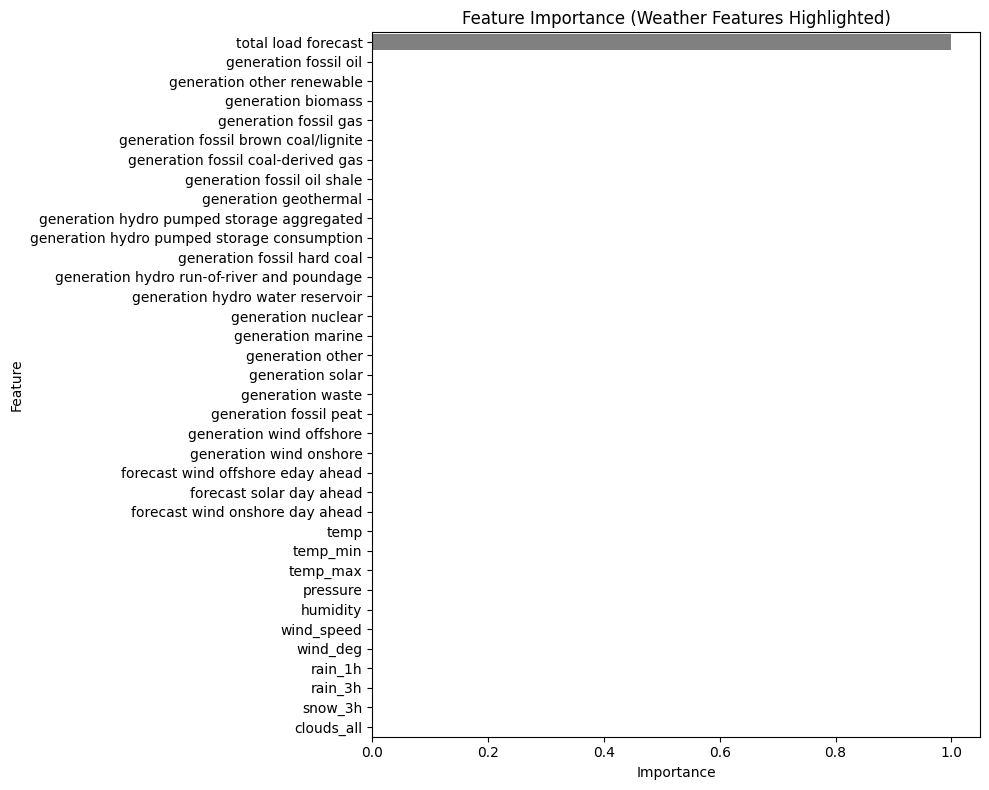

In [11]:
# 10. Feature Importance Plot
importances = best_rf.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Highlight weather features
weather_features = {'temp','temp_min','temp_max','pressure','humidity',
                    'wind_speed','wind_deg','rain_1h','rain_3h','snow_3h','clouds_all'}
colors = ['blue' if feat in weather_features else 'gray' for feat in importance_df['Feature']]

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette=colors)
plt.title('Feature Importance (Weather Features Highlighted)')
plt.tight_layout()
plt.show()


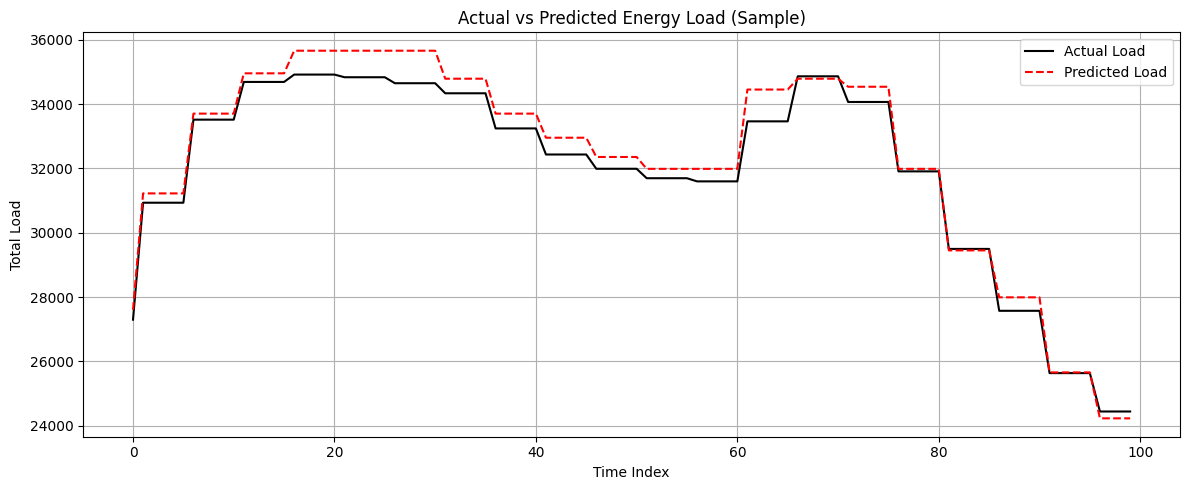

In [12]:
# 11. Sample Prediction Plot
plt.figure(figsize=(12, 5))
plt.plot(y_test.values[:100], label='Actual Load', color='black')
plt.plot(y_pred[:100], label='Predicted Load', color='red', linestyle='--')
plt.title('Actual vs Predicted Energy Load (Sample)')
plt.xlabel('Time Index')
plt.ylabel('Total Load')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()